In [1]:
import pandas as pd
df = pd.read_csv("C://Users//na488//Dropbox//yeast_starvation//results//modelling//combined_data_with_features.csv")



Doing the test-train split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



# Specify the target and features
target = 'ground_truth'
features = ['Linear Speed', 'Smoothed Speed 5s', 'Smoothed Speed 10s', 'Smoothed Speed 30s', 'Smoothed Speed 60s', 'Smoothed Speed 120s',
            'radial_velocity', 'Smoothed Radial Velocity 5s', 'Smoothed Radial Velocity 10s', 'Smoothed Radial Velocity 30s', 'Smoothed Radial Velocity 60s', 'Smoothed Radial Velocity 120s',
            'radial_acceleration', 'Smoothed Radial Acceleration 5s', 'Smoothed Radial Acceleration 10s', 'Smoothed Radial Acceleration 30s', 'Smoothed Radial Acceleration 60s', 'Smoothed Radial Acceleration 120s',
            'tangential_velocity', 'Smoothed Tangential Velocity 5s', 'Smoothed Tangential Velocity 10s', 'Smoothed Tangential Velocity 30s', 'Smoothed Tangential Velocity 60s', 'Smoothed Tangential Velocity 120s',
            'tangential_acceleration', 'Smoothed Tangential Acceleration 5s', 'Smoothed Tangential Acceleration 10s', 'Smoothed Tangential Acceleration 30s', 'Smoothed Tangential Acceleration 60s', 'Smoothed Tangential Acceleration 120s',
            'radial_distance', 'Smoothed Radial Distance 5s', 'Smoothed Radial Distance 10s', 'Smoothed Radial Distance 30s', 'Smoothed Radial Distance 60s', 'Smoothed Radial Distance 120s']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)

Looking at the imbalance of our classes, and trying to balance them

In [3]:
print(y_train.value_counts())

##Since our data is heavily imbalanced, we use SMOTE to oversample our minority class, and RandomUndersampler to undersample our majority class

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Define the number of samples for each class
sampling_strategy_over = {'Local_Search': 14000, 'Exploitation': 14000}  # replace with your class labels and desired number of samples
sampling_strategy_under = {'Exploration': 14000}  # replace with your class labels and desired number of samples


# Define pipeline
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

# Apply the pipeline to the training data
X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)

print(y_train_res.value_counts())


ground_truth
Exploration     74134
Local_Search    13378
Exploitation    11244
Name: count, dtype: int64
ground_truth
Exploitation    14000
Exploration     14000
Local_Search    14000
Name: count, dtype: int64


Initializing and Fitting the model. Using best hyperparameters found in an earlier code to guide this.

In [4]:
# Create and fit the model
model = RandomForestClassifier(n_estimators=285, max_depth=14, random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)

In [23]:
print(model.classes_)

['Exploitation' 'Exploration' 'Local_Search']


**Our model is now trained. Now we will calculate some parameters to see how good it is.** First we plot the confusion matrix and the most important features.

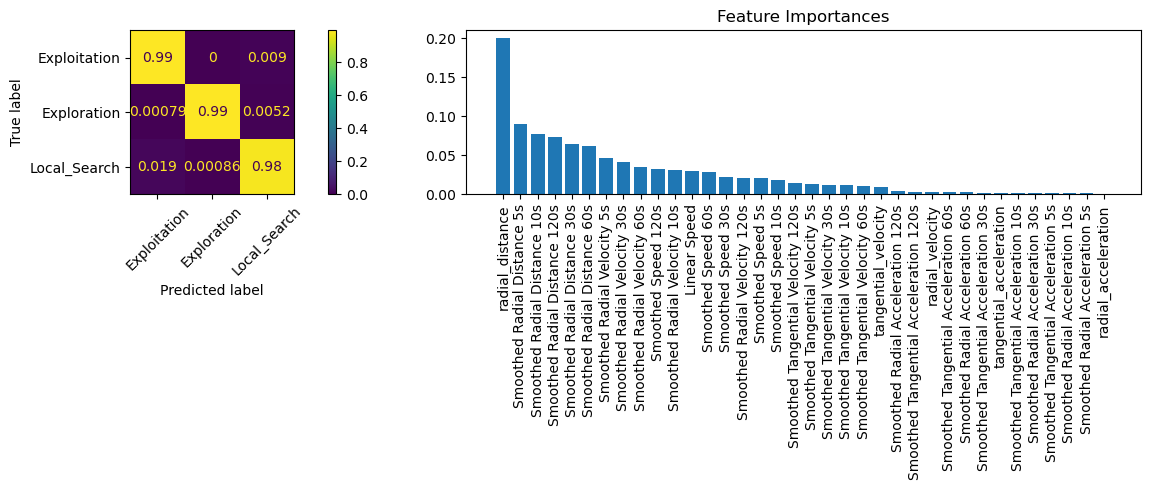

In [5]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the normalized confusion matrix on the first subplot
cm = confusion_matrix(y_test, y_pred)
# Display the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=model.classes_)
disp.plot(ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

# Get the feature importances and their indices sorted in descending order
importances_sorted_index = model.feature_importances_.argsort()[::-1]
importances_sorted = model.feature_importances_[importances_sorted_index]

# Plot the sorted feature importances on the second subplot
ax[1].bar(range(len(importances_sorted)), importances_sorted)
ax[1].set_xticks(range(len(importances_sorted)))
ax[1].set_xticklabels(X_train.columns[importances_sorted_index], rotation=90)  # replace with your feature names
ax[1].set_title('Feature Importances')

plt.tight_layout()
plt.show()

Now we will do a Accuracy and Precision of report of the whole model, and also of the individual classes

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Calculate AUC-ROC
# Note: roc_auc_score can only be used for binary classification or multilabel classification, not multiclass
if len(set(y_test)) == 2:
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"AUC-ROC: {auc_roc}")

from sklearn.metrics import classification_report

print(classification_report(y_pred, y_test))

Accuracy: 0.9917540875153578
Precision: 0.9918907887520435
Recall: 0.9917540875153578
F1 Score: 0.9917976911678272
              precision    recall  f1-score   support

Exploitation       0.99      0.97      0.98      4870
 Exploration       0.99      1.00      1.00     31578
Local_Search       0.98      0.96      0.97      5876

    accuracy                           0.99     42324
   macro avg       0.99      0.98      0.98     42324
weighted avg       0.99      0.99      0.99     42324



**Our model is now trained! Now we will do a K-fold Cross validation.**  **WARNING ! :This step is time consuming !!!!**

K-Fold Cross Validation provides a more robust measure of the performance of a machine learning model than a single train/test split. It does this by dividing the dataset into 'K' subsets (or 'folds') and then iteratively training the model K times, each time using a different fold as the test set and the remaining K-1 folds as the training set.

The result is K estimates of the model's performance, rather than just one. These can then be averaged to provide a more accurate estimate of the model's true performance.

In addition to providing a more accurate performance estimate, K-Fold Cross Validation also gives an idea of how stable the model's performance is. If the performance across the K folds varies widely, this suggests that the model is sensitive to the specific training data used and might not generalize well to unseen data.

Next steps:
- Consider the variability of the cross-validation scores in addition to the average score.
- If the scores vary widely, consider adjusting the model's parameters or using a different model.
- If you encounter any issues, please provide more details.

In [14]:
from sklearn.model_selection import cross_val_score

# Create the model
model = RandomForestClassifier(n_estimators=285, max_depth=14, random_state=42)

# Perform K-Fold Cross Validation
scores = cross_val_score(model, X_train_res, y_train_res, cv=5)

print("Cross-validation scores: ", scores)
print("Average cross-validation score: ", scores.mean())

Cross-validation scores:  [0.98547619 0.98595238 0.9872619  0.98178571 0.98369048]
Average cross-validation score:  0.9848333333333334


It seems like our model is performing well for all classes and across different splits of Test and Train. Now its time to feed it new data and see how it performs !

In [22]:
csv_file_path = "C://Users//na488//Dropbox//yeast_starvation//results//modelling//ground_truth.csv"


In [23]:

import feature_calculations as fc
df= fc.feature_calculation(csv_file_path)

Calculating linear speed
Calculating angular velocity
Calculating angular acceleration
Calculating radial velocity
Calculating radial acceleration
Calculating tangential velocity
Calculating tangential acceleration
Calculating radial distance
doing some cleaning
ground_truth
0    29033
1     5928
2     1495
Name: count, dtype: int64


In [25]:
df_an=df[df['animal'] == 2]
df_an=df_an.dropna()
df_feat_an=df_an[features]


In [26]:
new_predictions = model.predict(df_feat_an)

In [27]:
new_labels=df_an['ground_truth']

In [28]:
mapping2 = {0: 'Exploration', 1: 'Local_Search', 2: 'Exploitation'}
new_labels = new_labels.map(mapping2)

In [29]:
# Create a reverse mapping
reverse_mapping2 = {'Exploration': 0, 'Local_Search': 1, 'Exploitation': 2}

# Convert new_predictions and new_labels
new_predictions_bool = [reverse_mapping2[i] for i in new_predictions]
#new_labels = [reverse_mapping2[i] for i in new_labels]
new_labels_bool = [reverse_mapping2[i] if i in reverse_mapping2 else print(f"Unmapped value at index {idx} in new_labels: {i}") or i for idx, i in enumerate(new_labels)]

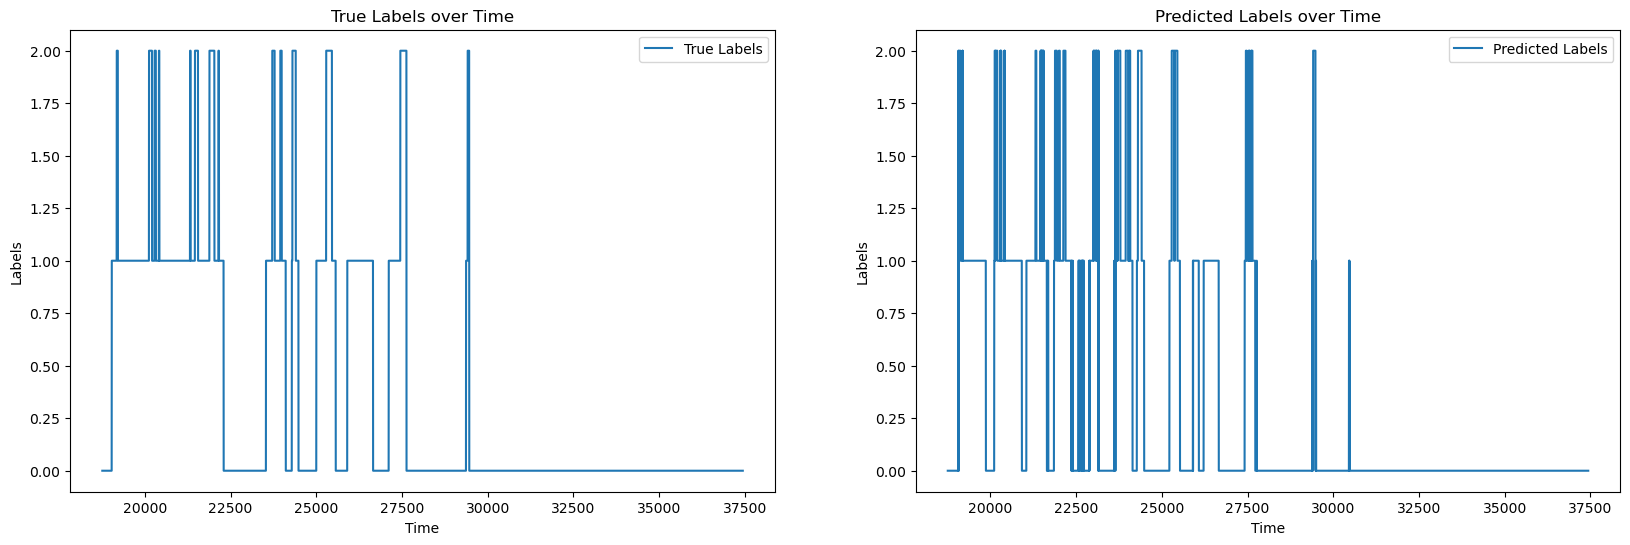

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot new_labels over time in the first subplot
axs[0].plot(df_an['timebin'], new_labels_bool, label='True Labels')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Labels')
axs[0].set_title('True Labels over Time')
axs[0].legend()

# Plot new_predictions over time in the second subplot
axs[1].plot(df_an['timebin'], new_predictions_bool, label='Predicted Labels')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Labels')
axs[1].set_title('Predicted Labels over Time')
axs[1].legend()

plt.show()

In [31]:
from sklearn.metrics import classification_report

print(classification_report(new_labels, new_predictions))

              precision    recall  f1-score   support

Exploitation       0.71      0.74      0.72      1052
 Exploration       0.88      0.94      0.91     11891
Local_Search       0.80      0.66      0.73      4910

    accuracy                           0.85     17853
   macro avg       0.80      0.78      0.79     17853
weighted avg       0.85      0.85      0.85     17853

